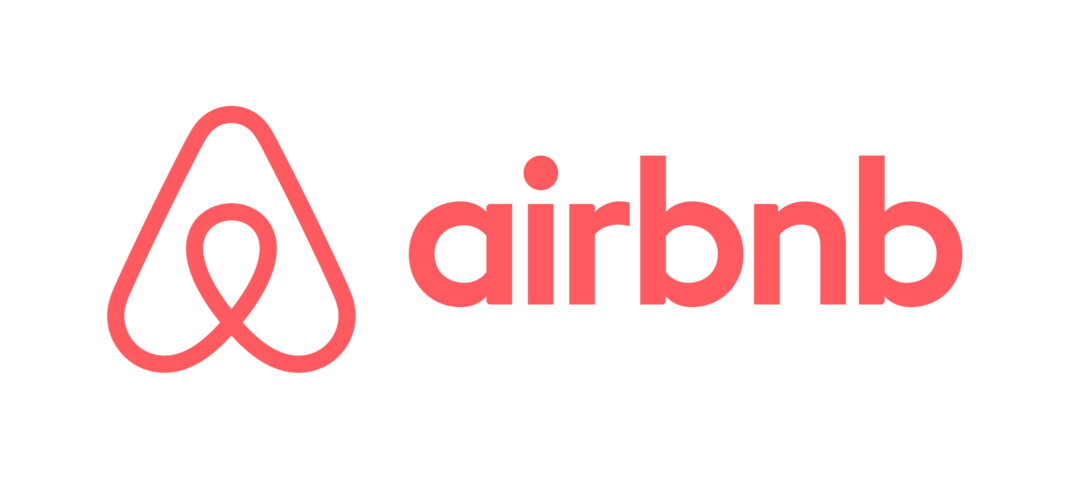

In [2]:
Image('img/airbnb.png')

<h1>Airbnb New User Bookings</h1>

<h3>Where will a new guest book their first travel experience?<h/3>

Instead of waking to overlooked "Do not disturb" signs, Airbnb travelers find themselves rising with the birds in a whimsical treehouse, having their morning coffee on the deck of a houseboat, or cooking a shared regional breakfast with their hosts.

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

In this business problem, Airbnb launched a challenge to predict in which country a new user will make his or her first booking.

<h3>Understanding the business problem</h3><br>

 - Problem Propose:
 
      - Prediction of the first destination a new user will choose.
            
            
  - What kind of Airbnb business model?
 
      - Marketplace (Connect people offering accommodation with people looking for accommodation)

<h1>Index</h1>

 - 0.0. IMPORTS
 - 1.0. DATA DESCRIPTION
 - 2.0. DATA FILTERING
 - 3.0. EXPLORATORY DATA ANALYSIS
 - 4.0. DATA PREPARATION
 - 5.0. FEATURE SELECTION
 - 6.0. MACHINE LEARNING MODELLING
 - 7.0. HYPERPARAMETER FINE TUNING
 - 8.0. TRANSLATION AND MODEL'S INTERPERTATION
 - 9.0 MODEL DEPLOY TO PREDICTION

# 0.0. IMPORTS

In [69]:
import pandas                as pd
import numpy                 as np

import matplotlib.pyplot     as plt
import seaborn               as sns

from IPython.core.display    import HTML
from IPython.display         import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import accuracy_score

from keras import models     as ml
from keras import layers     as l

## 0.1. Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [6]:
df_raw = pd.read_csv('data/training_users.csv', low_memory=True)
df_raw.shape

(213451, 16)

# 1.0. DATA DESCRIPTION

In [7]:
df1 = df_raw.copy()

In [8]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [9]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 213451
Number of columns: 16


<br/>

In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

<h2>File descriptions</h2>

**train_users.csv** - the training set of users<br>
**test_users.csv** - the test set of users
 - id: user id
 - date_account_created: the date of account creation
 - timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or  - date_first_booking because a user can search before signing up
 - date_first_booking: date of first booking
 - gender
 - age
 - signup_method
 - signup_flow: the page a user came to signup up from
 - language: international language preference
 - affiliate_channel: what kind of paid marketing
 - affiliate_provider: where the marketing is e.g. google, craigslist, other
 - first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
 - signup_app
 - first_device_type
 - first_browser
 - country_destination: this is the target variable you are to predict

**sessions.csv** - web sessions log for users
 - user_id: to be joined with the column 'id' in users table
 - action
 - action_type
 - action_detail
 - device_type
 - secs_elapsed

**countries.csv** - summary statistics of destination countries in this dataset and their locations<br>
**age_gender_bkts.csv** - summary statistics of users' age group, gender, country of destination<br>
**sample_submission.csv** - correct format for submitting your predictions

 - Data Source: https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/overview <br/>

## 1.1. Data Types

In [10]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.2. Check N/A's

In [11]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

## 1.3. Fillout N/A's

In [12]:
# drop N/A's
df1 = df1.dropna()
print(f"Number of rows (after dropping N/A's values): {df1.shape[0]}")

Number of rows (after dropping N/A's values): 68171


## 1.4. Change Data Type

In [13]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( int )

In [14]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.5. Data Description

In [15]:
df1.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [16]:
df1['gender'].value_counts()

FEMALE       29863
MALE         26168
-unknown-    11979
OTHER          161
Name: gender, dtype: int64

In [17]:
# value_counts in percentage for each country
df1['country_destination'].value_counts( normalize=True ).round(4) * 100

US       70.89
other    11.09
FR        5.41
IT        2.98
GB        2.59
ES        2.49
CA        1.57
DE        1.25
NL        0.88
AU        0.64
PT        0.23
Name: country_destination, dtype: float64

# 2.0. DATA FILTERING

In [54]:
df2 = df1.copy()

## 2.1. Filtering Rows

## 2.2. Columns Selection

# 4.0. FEATURE SELECTION

In [55]:
df3 = df2.copy()

In [56]:
df3_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis=1 ) )
df3 = pd.concat( [df3[['id', 'country_destination']], df3_dummy ], axis=1 )

In [57]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']
df4 = df3.drop( cols_drop , axis=1 )

# 5.0. MACHINE LEARNING MODEL - Neural Network MLP

In [58]:
X = df4.drop( 'country_destination', axis=1 )
y = df4['country_destination'].copy()

In [59]:
# split dataset into training and test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=32 )

In [60]:
# dropping id column
x_train = X_train.drop( 'id', axis=1 )
x_test = X_test.drop( 'id', axis=1 )

In [61]:
# One Hot Encoder
one_hot_encod = OneHotEncoder()
y_train_nn = one_hot_encod.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [62]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 128 ,input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 11, activation='softmax' ) )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.3703 - accuracy: 0.7047
Epoch 2/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2665 - accuracy: 0.7069
Epoch 3/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.2432 - accuracy: 0.7078
Epoch 4/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2254 - accuracy: 0.7084
Epoch 5/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2022 - accuracy: 0.7083
Epoch 6/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1797 - accuracy: 0.7086
Epoch 7/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1681 - accuracy: 0.7085
Epoch 8/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1519 - accuracy: 0.7088
Epoch 9/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1477 - accuracy: 0.7086
Epoch 10/100
1705/1705 [==============================] - 3s 2ms/step - l

1705/1705 [==============================] - 2s 1ms/step - loss: 1.0986 - accuracy: 0.7120
Epoch 80/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0984 - accuracy: 0.7119
Epoch 81/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0982 - accuracy: 0.7118
Epoch 82/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0982 - accuracy: 0.7116
Epoch 83/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0979 - accuracy: 0.7121
Epoch 84/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0977 - accuracy: 0.7121
Epoch 85/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0975 - accuracy: 0.7120
Epoch 86/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0976 - accuracy: 0.7121
Epoch 87/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0972 - accuracy: 0.7122
Epoch 88/100
1705/1705 [==============================] - 2s 1ms/step - loss:

# 6.0. NN PERFORMANCE

In [68]:
# prediction
y_test_nn = model.predict( x_test )

# invert 
yhat_nn = one_hot_encod.inverse_transform( y_test_nn )

# prediction preparation
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

In [77]:
accuracy_nn = accuracy_score( y_test_nn, yhat_nn )
print(f'Accuracy: {accuracy_nn * 100:.2f}%')

Accuracy: 70.12%
